In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Verify TensorFlow version and Keras version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.1


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


In [6]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15332587630743262395
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5750390784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12878276378203235110
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')

In [10]:
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

In [11]:
text_only_dataset_all=dataset_all.map(lambda x, y: x)

In [12]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [13]:
categories =dict(enumerate(info.features["label"].names))
print(f'Dictionary: ',categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [14]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [15]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [16]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [17]:
STOPWORDS

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
##############################################
# GLOBAL layers.TextVectorization() Settings #
##############################################
max_tokens=None # default
output_sequence_length=96 # Variation
# STOPWORDS: default nltk stopwords

In [19]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
# %%time
# ##################
# # EDA variation: #
# ##################
# # max_tokens=None # DEFAULT
# # output_sequence_length=96 # Variation

# text_vectorization=layers.TextVectorization(
#     max_tokens=max_tokens,
#     output_mode="int",
#     standardize=custom_stopwords,
#     output_sequence_length=output_sequence_length
# )
# text_vectorization.adapt(text_only_dataset_all)

In [ ]:
# %%time
# doc_sizes = []
# corpus = []
# for example, _ in dataset_all.as_numpy_iterator():
#   enc_example = text_vectorization(example)
#   doc_sizes.append(len(enc_example))
#   corpus+=list(enc_example.numpy())

In [ ]:
# print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
# print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

In [ ]:
# print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")

In [ ]:
# vocab = np.array(text_vectorization.get_vocabulary())
# print(vocab[:50])

In [ ]:
# plt.figure(figsize=(15,9))
# plt.hist(doc_sizes, bins=20,range = (0,80))
# plt.xlabel("Tokens Per Document")
# plt.ylabel("Number of AG News Articles");

## Experiments: Dataset Split

- split into train, validation, test datasets

In [20]:
dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

## layers.TextVectorization() Settings

- max_tokens: None (Default)
- output_sequence_length: 96 (VARIABLE)
- STOPWORDS: default nltk stopwords

In [21]:
print(output_sequence_length)

96


In [22]:
print(max_tokens)

None


In [23]:
%%time
###################################################
# layers.TextVectorization() Experiment Settings: #
###################################################
# max_tokens=None # default
# output_sequence_length=96 # Variation
# STOPWORDS: default nltk stopwords

# Experiment layers.TextVectorization(): text_vectorization_exp

text_vectorization_exp = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords,
    output_sequence_length=output_sequence_length
)
text_vectorization_exp.adapt(text_only_train_ds)

CPU times: total: 16.8 s
Wall time: 6.45 s


In [24]:
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization_exp(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization_exp(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization_exp(x), y),
    num_parallel_calls=4)

### Experiment 1: LSTM

- layers.TextVectorization(output_sequence_length): 96 (variable)
- layers.Dropout(dropout): 0.2 (constant)
- layers.Bidirectional(layers.LSTM(units)): 32 (constant)
- layers.Embedding(output_dim): 64 (variable)
- layers.Embedding(output_dim): 1000 (constant)

In [27]:
# output_sequence_length=96 # variable
dropout = 0.2 # constant
units = 32 # constant
output_dim = 64 # variable
input_dim = 1000 # constant

In [25]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_01 = tf.keras.Model(inputs, outputs)
model_01.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_01.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_01_osl_96_od_64.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model_01.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model_01 = keras.models.load_model("LSTM_01_osl_96_od_64.h5")
print(f"Test acc: {model_01.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 89,092
Trainable params: 89,092
Non-trainable params: 0
_________________________________________________________

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
6,0.358,0.872,0.379,0.867
7,0.351,0.875,0.376,0.868
8,0.345,0.877,0.381,0.868
9,0.339,0.879,0.388,0.865
10,0.332,0.882,0.384,0.865


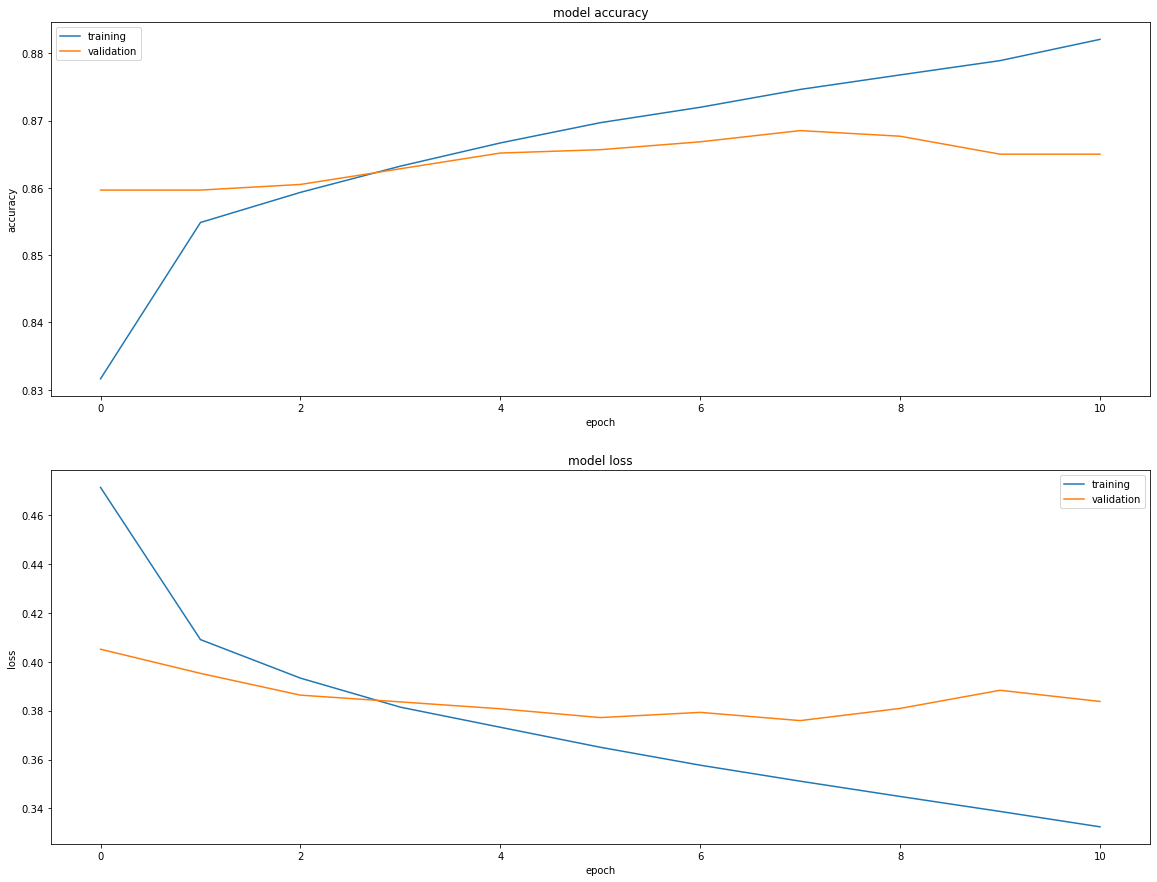

In [30]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [32]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_01.predict(int_test_ds), axis=-1)

238/238 [==============================] - 7s 13ms/step


In [33]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1900
           1       0.91      0.93      0.92      1900
           2       0.86      0.80      0.83      1900
           3       0.82      0.83      0.83      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8609210526315789
Root Mean Square Error: 0.65484027783398


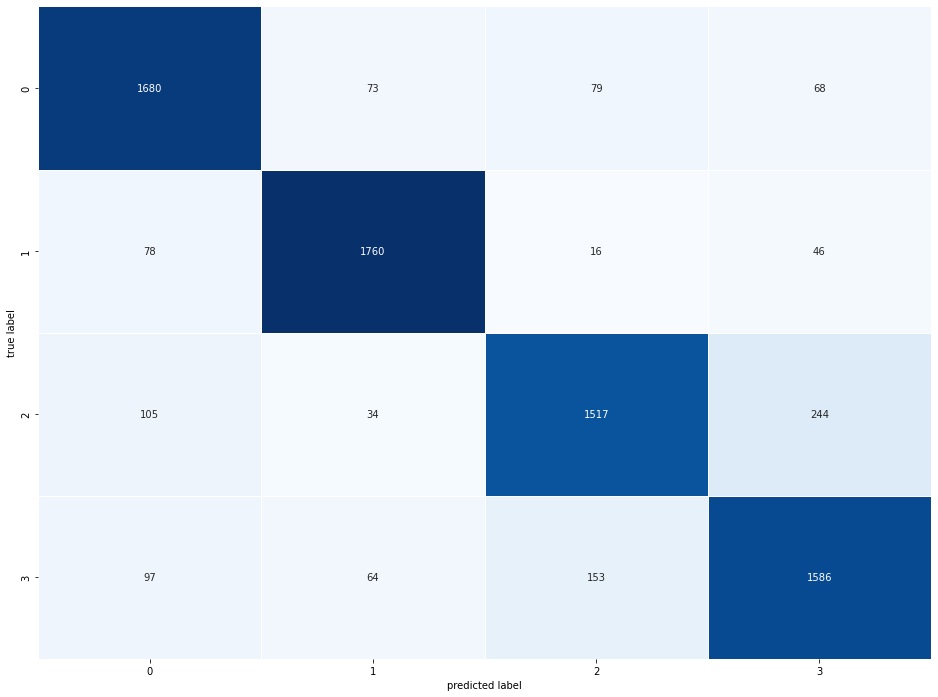

In [34]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 2: LSTM

- layers.TextVectorization(output_sequence_length): 96 (default)
- layers.Dropout(dropout): 0.2 (constant)
- layers.Bidirectional(layers.LSTM(units)): 32 (constant)
- layers.Embedding(output_dim): 128 (VARIABLE)
- layers.Embedding(input_dim): 1000 (constant)

In [28]:
output_dim = 128 # variable

In [29]:
print('input_dim:', input_dim)
print('output_dim:', output_dim)
print('units:', units)
print('dropout:', dropout)
print('output_sequence_length:', output_sequence_length)

input_dim: 1000
output_dim: 128
units: 32
dropout: 0.2
output_sequence_length: 96


In [30]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_02 = tf.keras.Model(inputs, outputs)
model_02.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_02.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_02_osl_96_od_1128.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model_02.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model_02 = keras.models.load_model("LSTM_02_osl_96_od_1128.h5")
print(f"Test acc: {model_02.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 169,476
Trainable params: 169,476
Non-trainable params: 0
_______________________________________________________

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
7,0.340,0.879,0.377,0.864
8,0.332,0.882,0.378,0.867
9,0.322,0.886,0.382,0.865
10,0.315,0.888,0.380,0.865
11,0.306,0.892,0.388,0.864


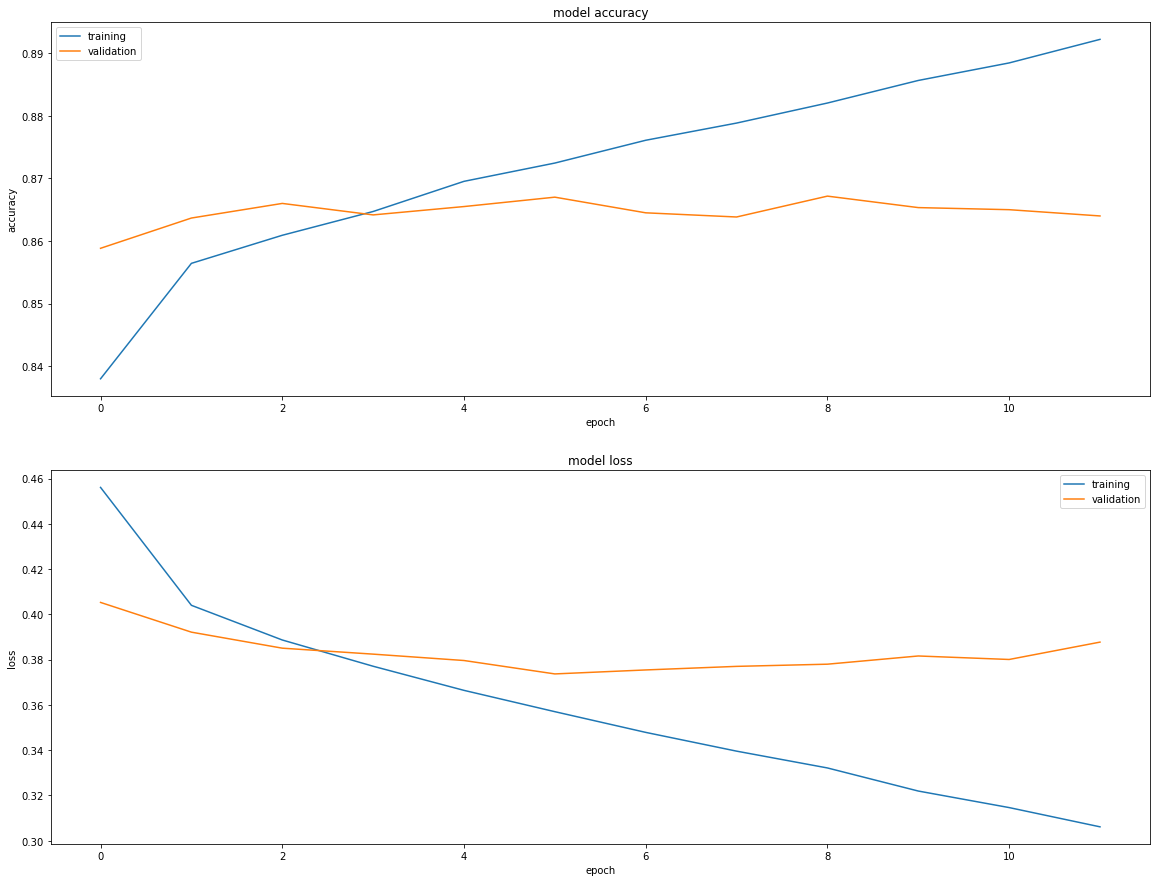

In [33]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [34]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_02.predict(int_test_ds), axis=-1)

238/238 [==============================] - 4s 7ms/step


In [35]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1900
           1       0.91      0.94      0.93      1900
           2       0.86      0.83      0.84      1900
           3       0.83      0.84      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8710526315789474
Root Mean Square Error: 0.6379448912018391


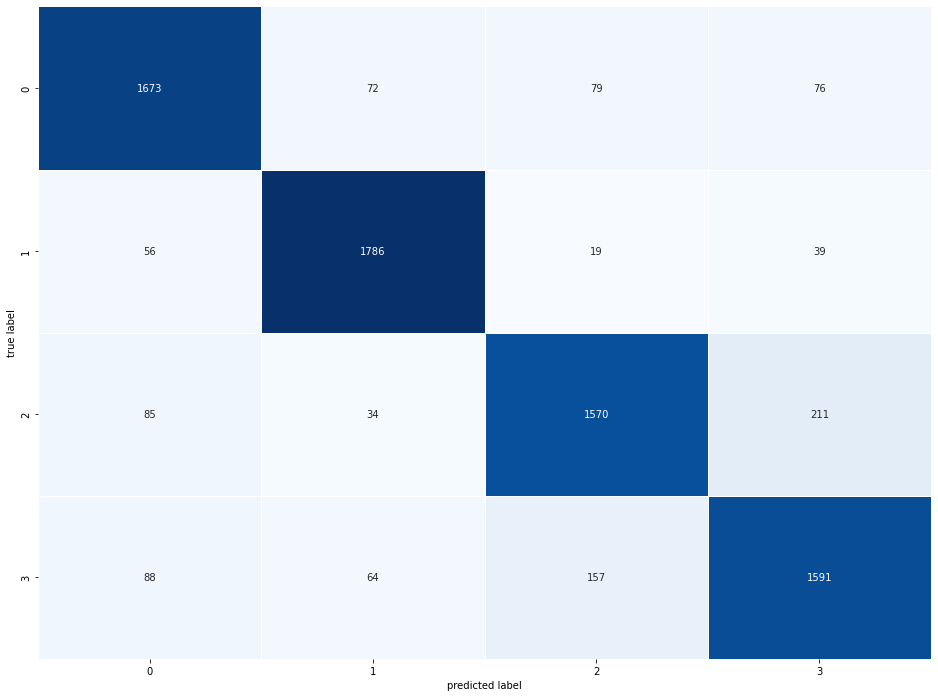

In [36]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 3: LSTM

- layers.TextVectorization(output_sequence_length): 96 (default)
- layers.Dropout(dropout): 0.2 (constant)
- layers.Bidirectional(layers.LSTM(units)): 32 (constant)
- layers.Embedding(output_dim): 256 (VARIABLE)
- layers.Embedding(input_dim): 1000 (constant)

In [28]:
output_dim = 256 # variable

In [29]:
print('input_dim:', input_dim)
print('output_dim:', output_dim)
print('units:', units)
print('dropout:', dropout)
print('output_sequence_length:', output_sequence_length)

input_dim: 1000
output_dim: 256
units: 32
dropout: 0.2
output_sequence_length: 96


In [30]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_03 = tf.keras.Model(inputs, outputs)
model_03.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_03.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_03_osl_96_od_256.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model_03.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model_03 = keras.models.load_model("LSTM_03_osl_96_od_256.h5")
print(f"Test acc: {model_03.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               73984     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 330,244
Trainable params: 330,244
Non-trainable params: 0
_______________________________________________________

In [31]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
5,0.349,0.876,0.384,0.862
6,0.338,0.880,0.387,0.864
7,0.327,0.884,0.390,0.862
8,0.317,0.888,0.390,0.859
9,0.306,0.891,0.396,0.864


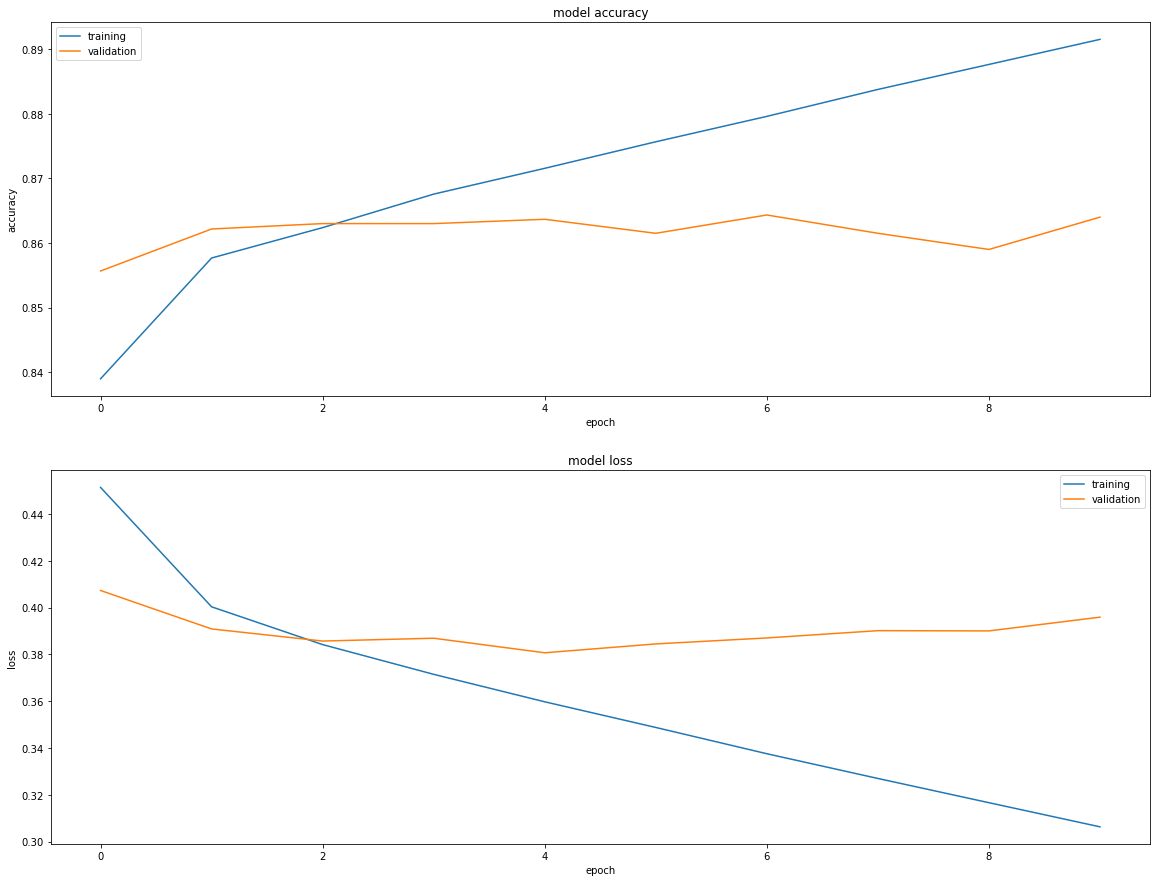

In [33]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [34]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_03.predict(int_test_ds), axis=-1)

238/238 [==============================] - 4s 6ms/step


In [35]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1900
           1       0.92      0.93      0.93      1900
           2       0.85      0.81      0.83      1900
           3       0.82      0.83      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8652631578947368
Root Mean Square Error: 0.647159786662988


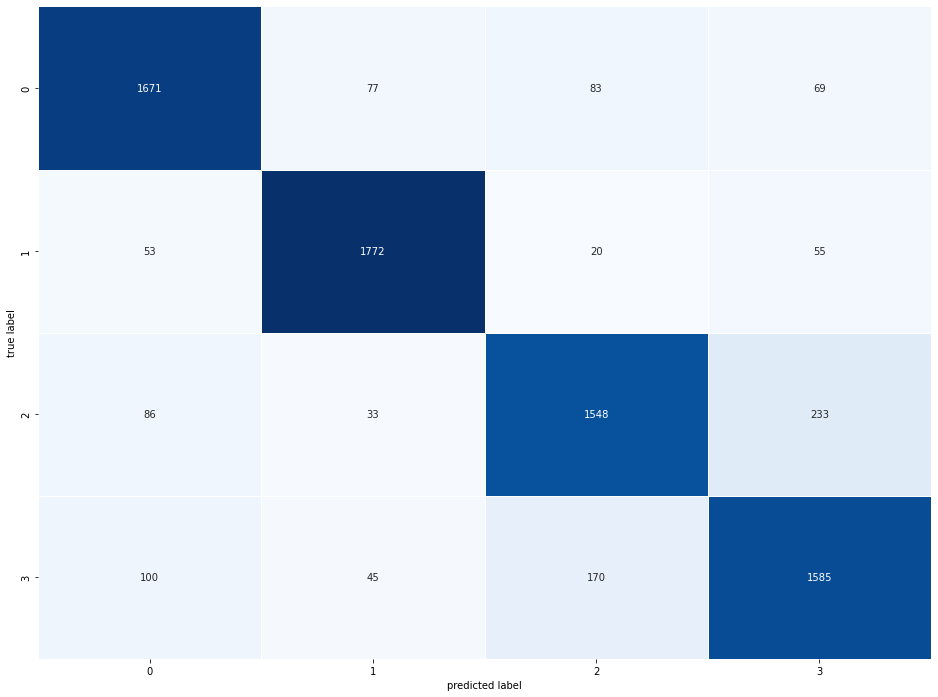

In [36]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 4: LSTM

- layers.TextVectorization(output_sequence_length): 96 (CONSANT)
- layers.Dropout(dropout): NONE (VARIABLE)
- layers.Bidirectional(layers.LSTM(units)): 32 (CONSANT)
- layers.Embedding(output_dim): 128 (CONSTANT)
- layers.Embedding(input_dim): 1000 (CONSANT)

In [37]:
# output_sequence_length=96 # CONSTANT
dropout = None # VARIABLE
units = 32 # CONSANT
output_dim = 128 # CONSANT
input_dim = 1000 # CONSANT

In [38]:
print('input_dim:', input_dim)
print('output_dim:', output_dim)
print('units:', units)
print('dropout:', dropout)
print('output_sequence_length:', output_sequence_length)

input_dim: 1000
output_dim: 128
units: 32
dropout: None
output_sequence_length: 96


In [41]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
# x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_04 = tf.keras.Model(inputs, outputs)
model_04.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_04.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 169,476
Trainable params: 169,476
Non-trainable params: 0
_________________________________________________________________


In [42]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_04_osl_96_od_128_do_none.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [43]:
history=model_04.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
3563/3563 [==============================] - 103s 26ms/step - loss: 0.4519 - accuracy: 0.8379 - val_loss: 0.4086 - val_accuracy: 0.8573
Epoch 2/200
3563/3563 [==============================] - 92s 26ms/step - loss: 0.4016 - accuracy: 0.8558 - val_loss: 0.3963 - val_accuracy: 0.8583
Epoch 3/200
3563/3563 [==============================] - 98s 27ms/step - loss: 0.3851 - accuracy: 0.8604 - val_loss: 0.3886 - val_accuracy: 0.8633
Epoch 4/200
3563/3563 [==============================] - 98s 28ms/step - loss: 0.3712 - accuracy: 0.8660 - val_loss: 0.3876 - val_accuracy: 0.8643
Epoch 5/200
3563/3563 [==============================] - 91s 26ms/step - loss: 0.3598 - accuracy: 0.8707 - val_loss: 0.3831 - val_accuracy: 0.8657
Epoch 6/200
3563/3563 [==============================] - 97s 27ms/step - loss: 0.3482 - accuracy: 0.8749 - val_loss: 0.3853 - val_accuracy: 0.8622
Epoch 7/200
3563/3563 [==============================] - 95s 27ms/step - loss: 0.3380 - accuracy: 0.8788 - val_loss: 

In [44]:
model_04 = keras.models.load_model("LSTM_04_osl_96_od_128_do_none.h5")
print(f"Test acc: {model_04.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 5s 11ms/step - loss: 0.3917 - accuracy: 0.8634
Test acc: 0.863


In [45]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.371,0.866,0.388,0.864
4,0.360,0.871,0.383,0.866
5,0.348,0.875,0.385,0.862
6,0.338,0.879,0.386,0.862
7,0.328,0.883,0.392,0.863


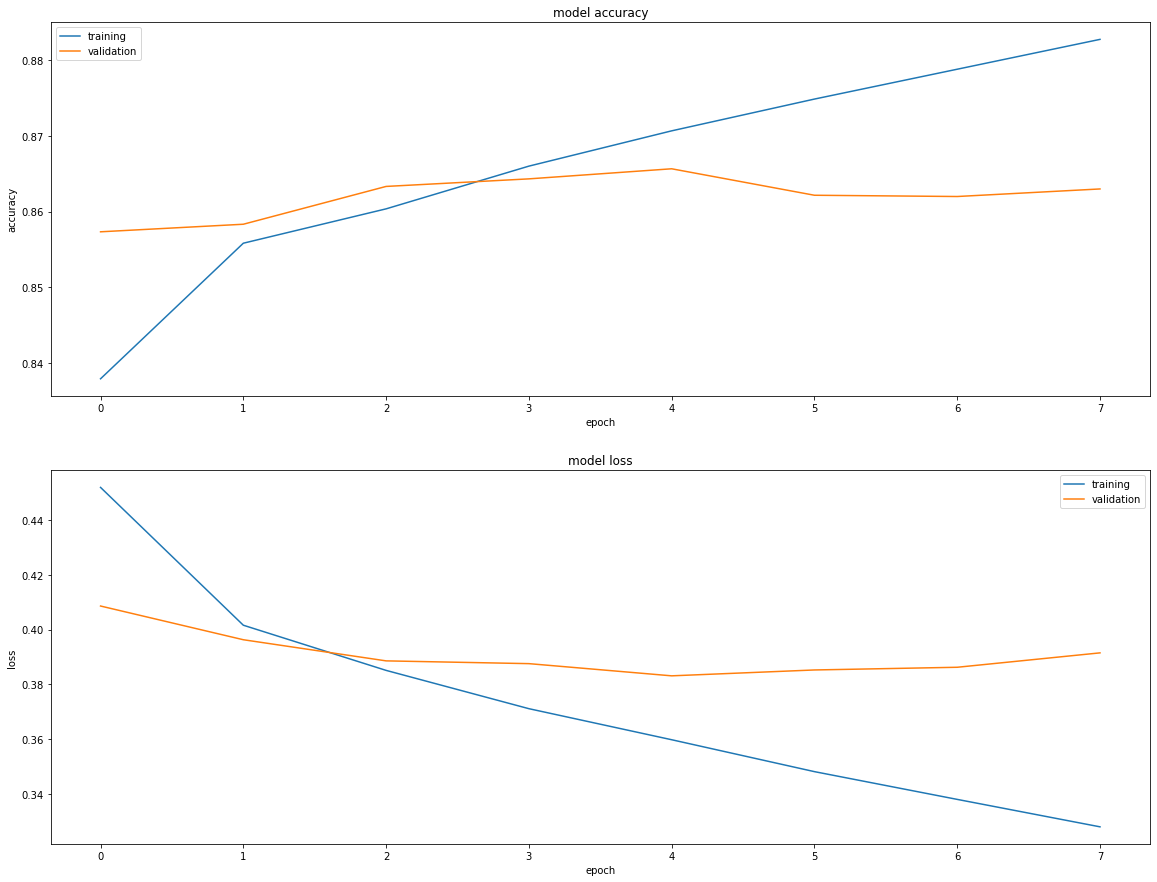

In [47]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [48]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_04.predict(int_test_ds), axis=-1)

238/238 [==============================] - 5s 9ms/step


In [49]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1900
           1       0.90      0.94      0.92      1900
           2       0.86      0.81      0.83      1900
           3       0.83      0.83      0.83      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8648684210526316
Root Mean Square Error: 0.651516449685291


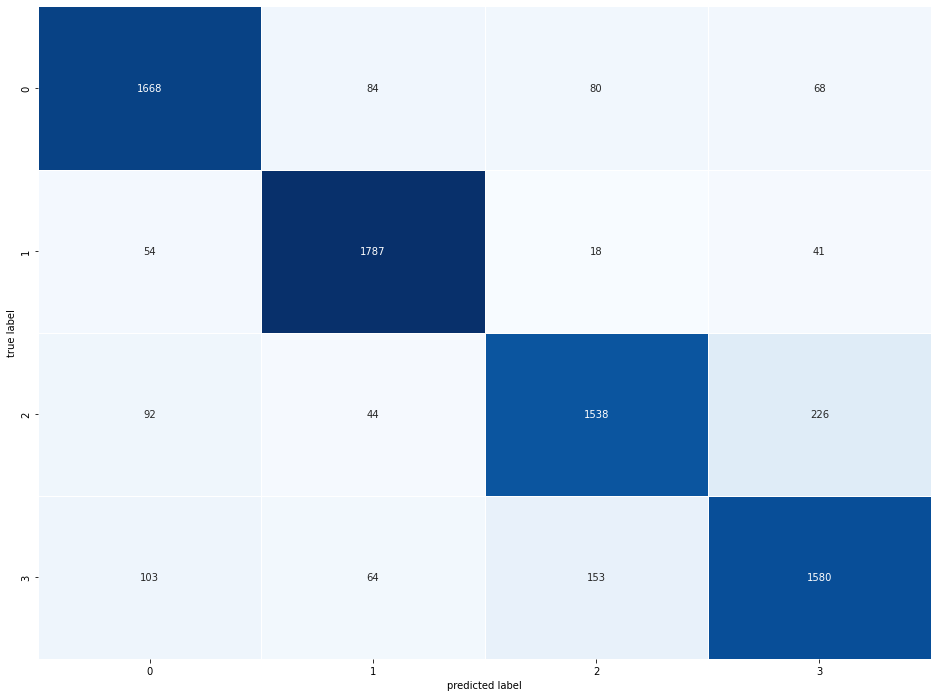

In [50]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 5: LSTM

- layers.TextVectorization(output_sequence_length): 96 (CONSTANT)
- layers.Dropout(dropout): 0.3 (VARIABLE)
- layers.Bidirectional(layers.LSTM(units)): 32 (CONSTANT)
- layers.Embedding(output_dim): 128 (CONSTANT)
- layers.Embedding(input_dim): 1000 (CONSANT)

In [51]:
# output_sequence_length=96 # CONSTANT
dropout = 0.3 # VARIABLE
# units = 32 # CONSTANT
# output_dim = 128 # CONSTANT
# input_dim = 1000 # CONSTANT

In [52]:
print('input_dim:', input_dim)
print('output_dim:', output_dim)
print('units:', units)
print('dropout:', dropout)
print('output_sequence_length:', output_sequence_length)

input_dim: 1000
output_dim: 128
units: 32
dropout: 0.3
output_sequence_length: 96


In [53]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_05 = tf.keras.Model(inputs, outputs)
model_05.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_05.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 169,476
Trainable params: 169,476
Non-trainable params: 0
_______________________________________________________

In [54]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_05_osl_96_od_128_do_03.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [55]:
history=model_05.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
3563/3563 [==============================] - 102s 27ms/step - loss: 0.4653 - accuracy: 0.8346 - val_loss: 0.4190 - val_accuracy: 0.8535
Epoch 2/200
3563/3563 [==============================] - 92s 26ms/step - loss: 0.4124 - accuracy: 0.8539 - val_loss: 0.4057 - val_accuracy: 0.8557
Epoch 3/200
3563/3563 [==============================] - 91s 26ms/step - loss: 0.3986 - accuracy: 0.8577 - val_loss: 0.4036 - val_accuracy: 0.8572
Epoch 4/200
3563/3563 [==============================] - 90s 25ms/step - loss: 0.3887 - accuracy: 0.8616 - val_loss: 0.3922 - val_accuracy: 0.8613
Epoch 5/200
3563/3563 [==============================] - 90s 25ms/step - loss: 0.3789 - accuracy: 0.8649 - val_loss: 0.3871 - val_accuracy: 0.8610
Epoch 6/200
3563/3563 [==============================] - 90s 25ms/step - loss: 0.3699 - accuracy: 0.8688 - val_loss: 0.3893 - val_accuracy: 0.8602
Epoch 7/200
3563/3563 [==============================] - 92s 26ms/step - loss: 0.3609 - accuracy: 0.8714 - val_loss: 

In [56]:
model_05 = keras.models.load_model("LSTM_05_osl_96_od_128_do_03.h5")
print(f"Test acc: {model_05.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 5s 10ms/step - loss: 0.3986 - accuracy: 0.8587
Test acc: 0.859


In [57]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.399,0.858,0.404,0.857
3,0.389,0.862,0.392,0.861
4,0.379,0.865,0.387,0.861
5,0.370,0.869,0.389,0.860
6,0.361,0.871,0.393,0.859


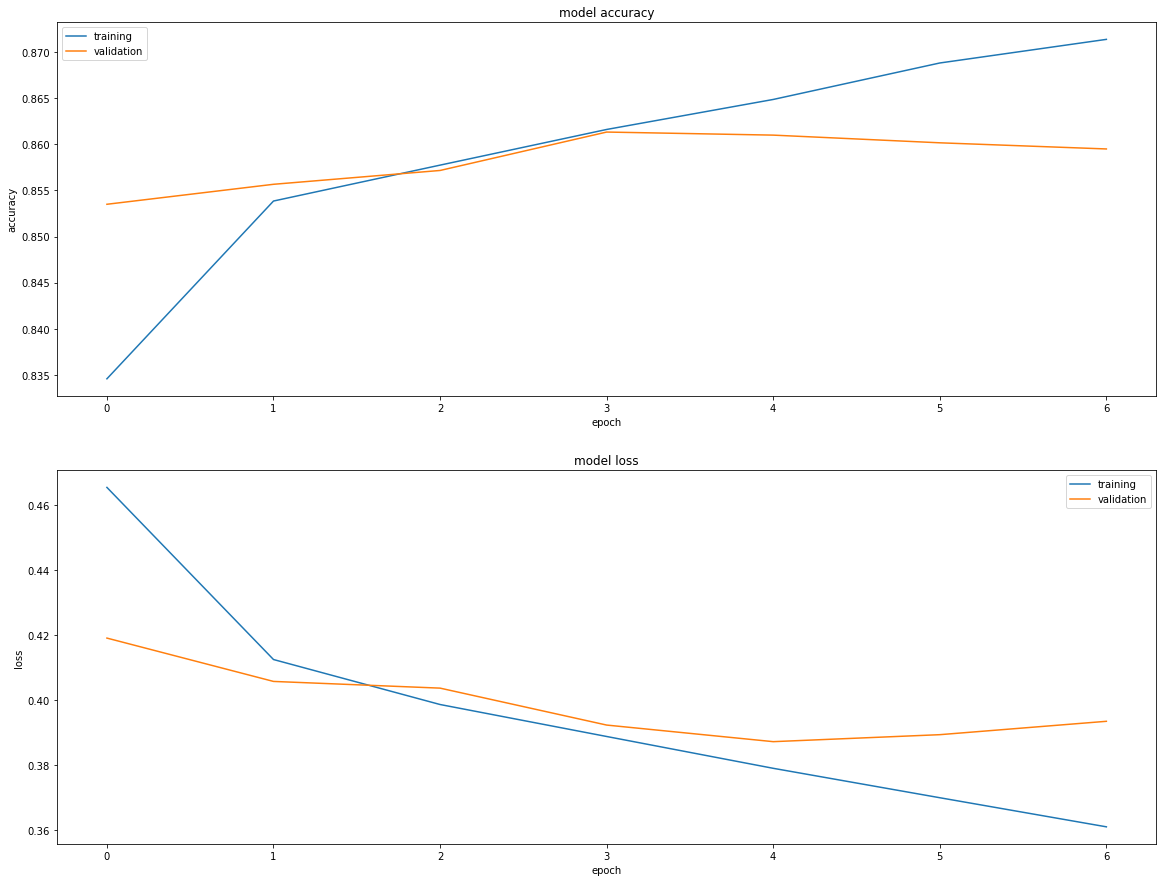

In [59]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [65]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_05.predict(int_test_ds), axis=-1)

238/238 [==============================] - 4s 8ms/step


In [66]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1900
           1       0.91      0.94      0.92      1900
           2       0.86      0.80      0.83      1900
           3       0.81      0.84      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8610526315789474
Root Mean Square Error: 0.6685609053859838


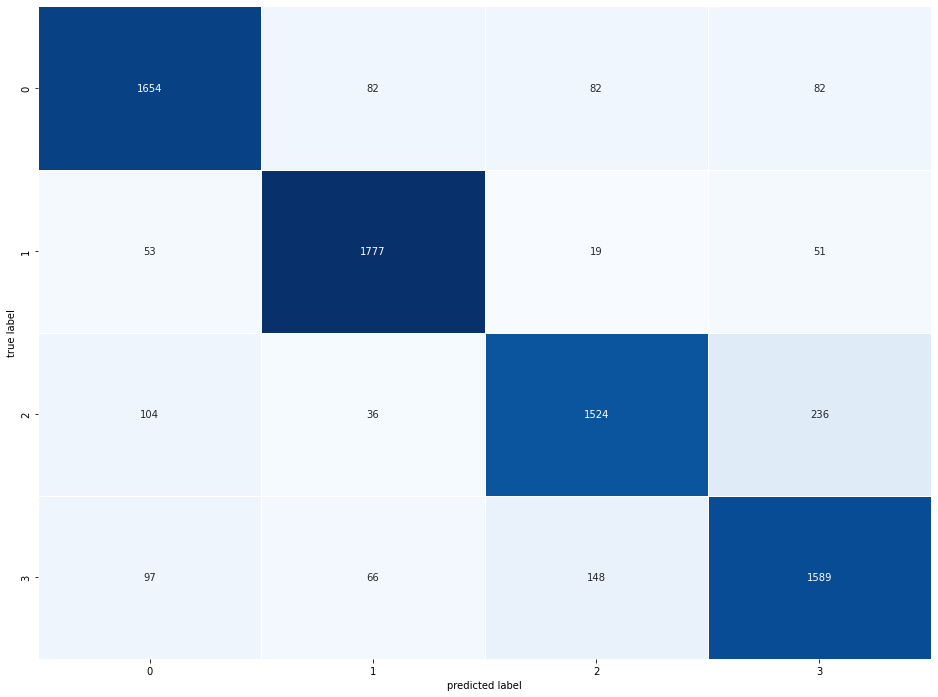

In [67]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 6: LSTM

- layers.TextVectorization(output_sequence_length): 96 (CONSTANT)
- layers.Dropout(dropout): 0.5 (VARIABLE)
- layers.Bidirectional(layers.LSTM(units)): 32 (CONSTANT)
- layers.Embedding(output_dim): 128 (CONSTANT)
- layers.Embedding(input_dim): 1000 (CONSANT)

In [68]:
# output_sequence_length=96 # CONSTANT
dropout = 0.5 # VARIABLE
# units = 32 # CONSTANT
# output_dim = 128 # CONSTANT
# input_dim = 1000 # CONSTANT

In [69]:
print('input_dim:', input_dim)
print('output_dim:', output_dim)
print('units:', units)
print('dropout:', dropout)
print('output_sequence_length:', output_sequence_length)

input_dim: 1000
output_dim: 128
units: 32
dropout: 0.5
output_sequence_length: 96


In [70]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=input_dim
                            ,output_dim=output_dim
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(units))(embedded)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_06 = tf.keras.Model(inputs, outputs)
model_06.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_06.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         128000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 169,476
Trainable params: 169,476
Non-trainable params: 0
_______________________________________________________

In [71]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM_06_osl_96_od_128_do_05.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [72]:
history=model_06.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
3563/3563 [==============================] - 100s 26ms/step - loss: 0.4795 - accuracy: 0.8326 - val_loss: 0.4212 - val_accuracy: 0.8518
Epoch 2/200
3563/3563 [==============================] - 98s 27ms/step - loss: 0.4242 - accuracy: 0.8517 - val_loss: 0.4096 - val_accuracy: 0.8557
Epoch 3/200
3563/3563 [==============================] - 90s 25ms/step - loss: 0.4105 - accuracy: 0.8561 - val_loss: 0.4018 - val_accuracy: 0.8597
Epoch 4/200
3563/3563 [==============================] - 94s 26ms/step - loss: 0.4023 - accuracy: 0.8583 - val_loss: 0.3978 - val_accuracy: 0.8618
Epoch 5/200
3563/3563 [==============================] - 90s 25ms/step - loss: 0.3936 - accuracy: 0.8608 - val_loss: 0.3978 - val_accuracy: 0.8603
Epoch 6/200
3563/3563 [==============================] - 95s 27ms/step - loss: 0.3871 - accuracy: 0.8639 - val_loss: 0.4004 - val_accuracy: 0.8600
Epoch 7/200
3563/3563 [==============================] - 102s 29ms/step - loss: 0.3798 - accuracy: 0.8669 - val_loss:

In [73]:
model_06 = keras.models.load_model("LSTM_06_osl_96_od_128_do_05.h5")
print(f"Test acc: {model_06.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 5s 11ms/step - loss: 0.4019 - accuracy: 0.8570
Test acc: 0.857


In [74]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [75]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
9,0.363,0.873,0.395,0.864
10,0.358,0.875,0.389,0.868
11,0.351,0.878,0.401,0.865
12,0.349,0.878,0.396,0.867
13,0.341,0.882,0.393,0.867


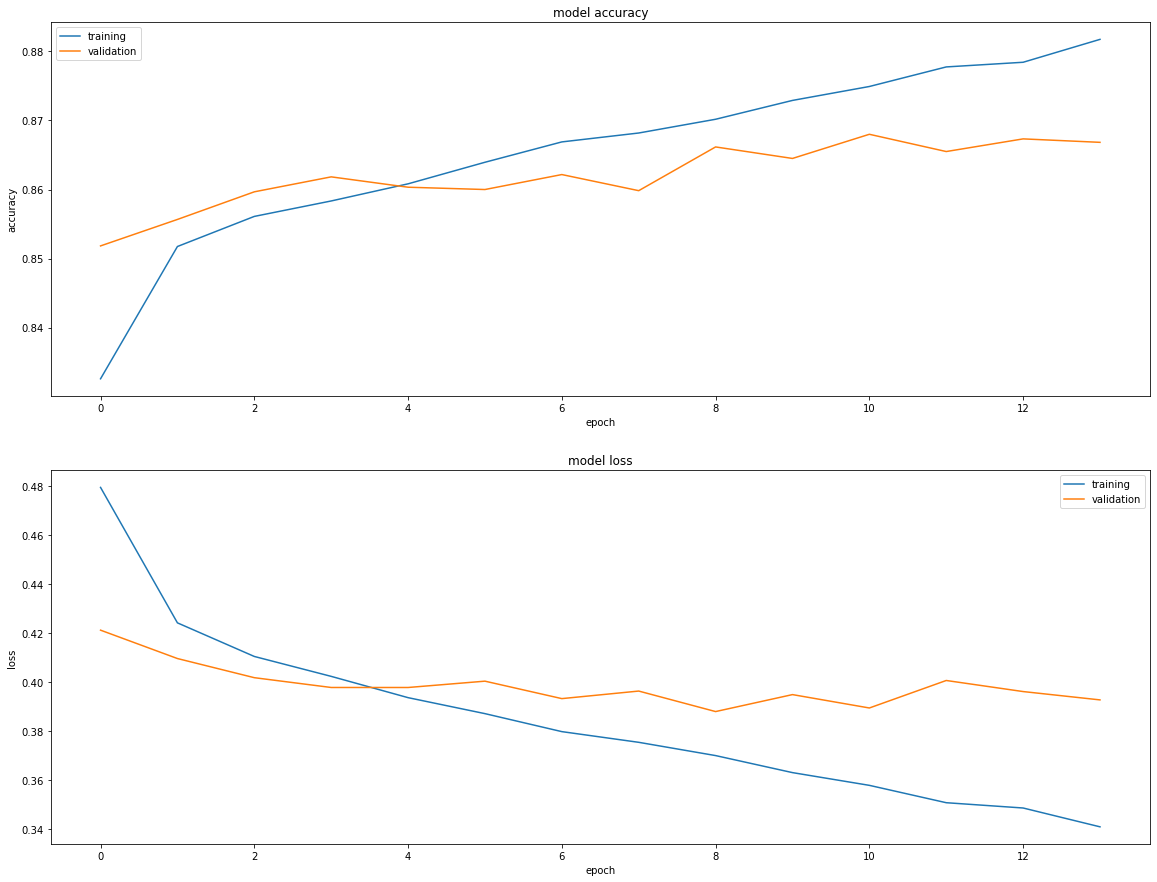

In [76]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [77]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_06.predict(int_test_ds), axis=-1)

238/238 [==============================] - 4s 8ms/step


In [78]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1900
           1       0.93      0.92      0.92      1900
           2       0.85      0.81      0.83      1900
           3       0.80      0.85      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600

Accuracy Score: 0.8607894736842105
Root Mean Square Error: 0.6681671710141502


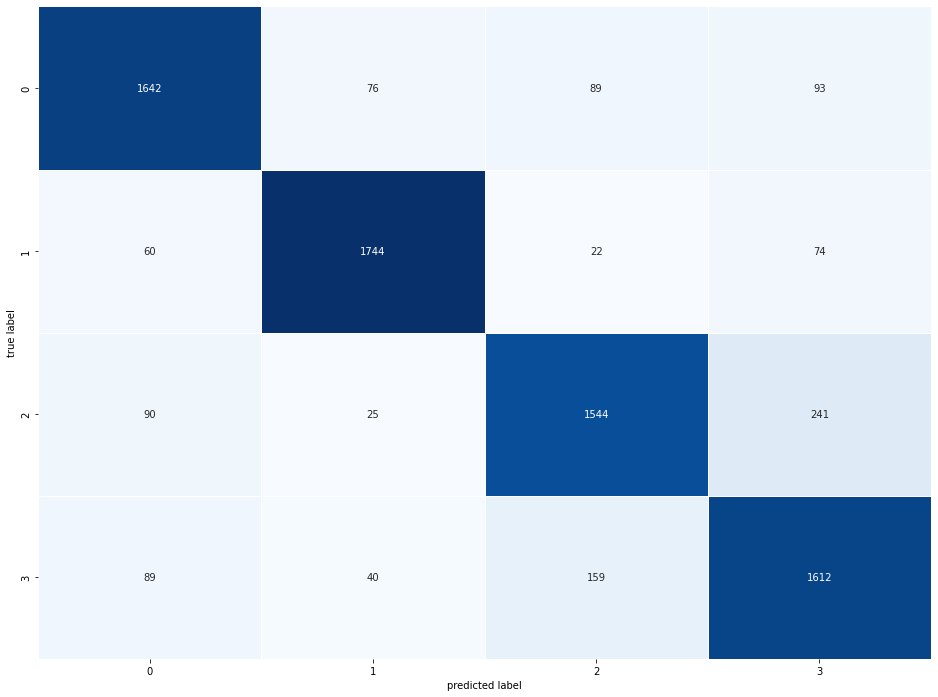

In [79]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 7: CNN 1D

- layers.TextVectorization(output_sequence_length): 96 (CONSTANT)
- layers.Dropout(dropout): 0.2 (CONSTANT)
- layers.Conv1D(kernel_size): 3 (VARIABLE)
- layers.Conv1D(filters): 32 (CONSTANT)
- layers.Embedding(depth): 1000 (CONSTANT)
- layers.Dense(units): 256 (CONSTANT)

In [83]:
# output_sequence_length=96 # CONSTANT
dropout = 0.2 # CONSTANT
kernel_size = 3 # VARIABLE
filters = 32 # CONSTANT
input_dim = 1000 # CONSTANT, embedded one-hot encoding depth
units = 256 # CONSTANT

In [84]:
print('dropout:', dropout)
print('kernel_size:', kernel_size)
print('filters:', filters)
print('input_dim:', input_dim) # embedded one-hot encoding depth
print('units:', units)
print('output_sequence_length:', output_sequence_length)

dropout: 0.2
kernel_size: 3
filters: 32
input_dim: 1000
units: 256
output_sequence_length: 96


In [85]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=input_dim)
x = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(embedded)
x = layers.Dropout(dropout)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(units, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_07 = tf.keras.Model(inputs, outputs)
model_07.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_07.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 1000)        0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          96032     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                              

In [86]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1Dcnn_07_osl_96_do_02_ker_3.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [87]:
history=model_07.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
3563/3563 [==============================] - 54s 7ms/step - loss: 0.5207 - accuracy: 0.8154 - val_loss: 0.4283 - val_accuracy: 0.8533
Epoch 2/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4345 - accuracy: 0.8471 - val_loss: 0.4249 - val_accuracy: 0.8538
Epoch 3/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4287 - accuracy: 0.8489 - val_loss: 0.4234 - val_accuracy: 0.8553
Epoch 4/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4250 - accuracy: 0.8506 - val_loss: 0.4270 - val_accuracy: 0.8543
Epoch 5/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4251 - accuracy: 0.8519 - val_loss: 0.4278 - val_accuracy: 0.8542
Epoch 6/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4265 - accuracy: 0.8527 - val_loss: 0.4330 - val_accuracy: 0.8508


In [88]:
model_07 = keras.models.load_model("1Dcnn_07_osl_96_do_02_ker_3.h5")
print(f"Test acc: {model_07.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 4ms/step - loss: 0.4368 - accuracy: 0.8487
Test acc: 0.849


In [89]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [90]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.434,0.847,0.425,0.854
2,0.429,0.849,0.423,0.855
3,0.425,0.851,0.427,0.854
4,0.425,0.852,0.428,0.854
5,0.427,0.853,0.433,0.851


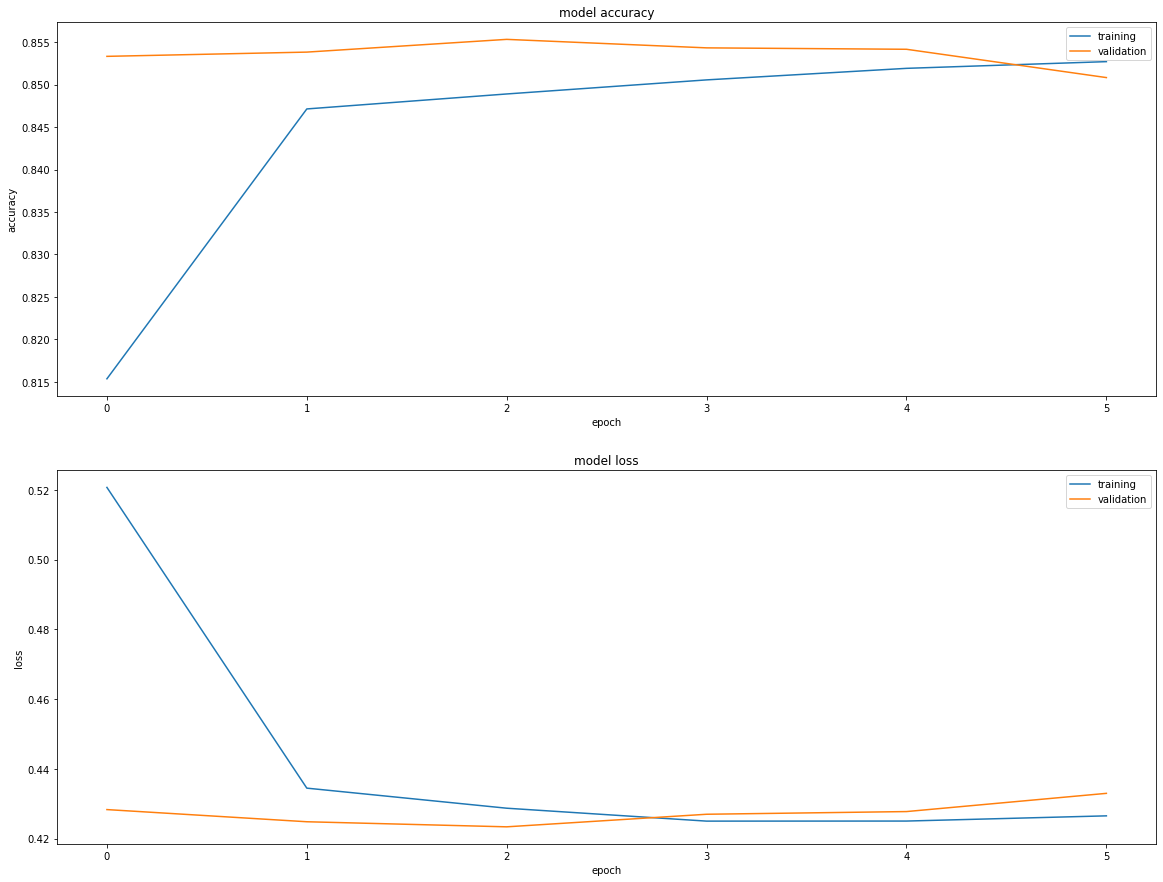

In [91]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [92]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_07.predict(int_test_ds), axis=-1)

238/238 [==============================] - 1s 3ms/step


In [93]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1900
           1       0.91      0.92      0.91      1900
           2       0.85      0.77      0.81      1900
           3       0.79      0.85      0.82      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Accuracy Score: 0.8486842105263158
Root Mean Square Error: 0.6827768380124767


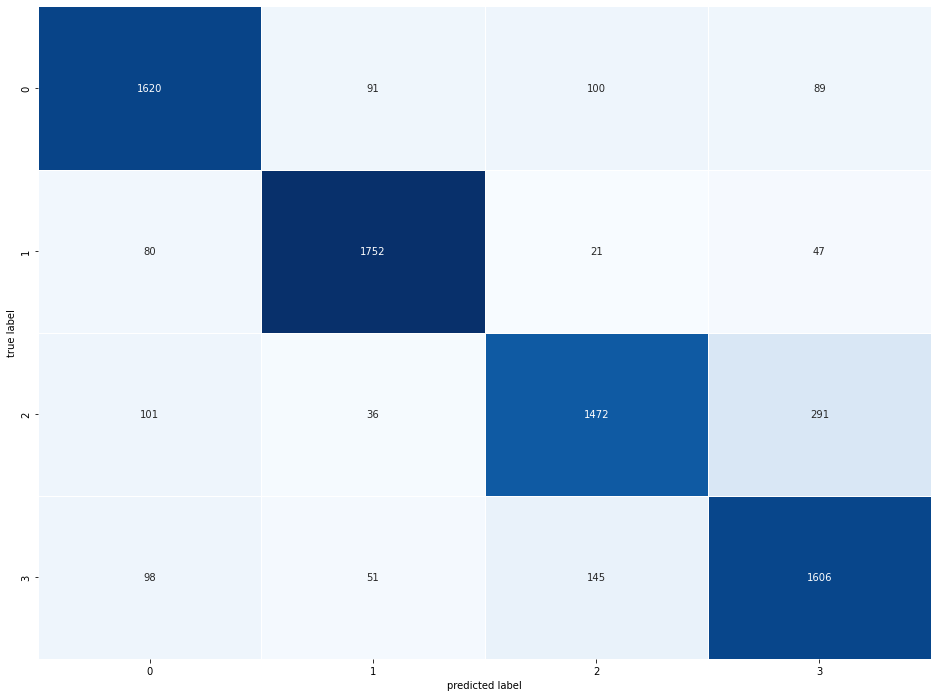

In [94]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 8: CNN 1D

- layers.TextVectorization(output_sequence_length): 96 (CONSTANT)
- layers.Dropout(dropout): 0.2 (CONSTANT)
- layers.Conv1D(kernel_size): 4 (VARIABLE)
- layers.Conv1D(filters): 32 (CONSTANT)
- layers.Embedding(depth): 1000 (CONSTANT)
- layers.Dense(units): 256 (CONSTANT)

In [95]:
# output_sequence_length=96 # CONSTANT
dropout = 0.2 # CONSTANT
kernel_size = 4 # VARIABLE
filters = 32 # CONSTANT
input_dim = 1000 # CONSTANT, embedded one-hot encoding depth
units = 256 # CONSTANT

In [96]:
print('dropout:', dropout)
print('kernel_size:', kernel_size)
print('filters:', filters)
print('input_dim:', input_dim) # embedded one-hot encoding depth
print('units:', units)
print('output_sequence_length:', output_sequence_length)

dropout: 0.2
kernel_size: 4
filters: 32
input_dim: 1000
units: 256
output_sequence_length: 96


In [98]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=input_dim)
x = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(embedded)
x = layers.Dropout(dropout)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(units, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_08 = tf.keras.Model(inputs, outputs)
model_08.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_08.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 1000)        0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          128032    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                              

In [99]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1Dcnn_08_osl_96_do_02_ker_4.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [100]:
history=model_08.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
3563/3563 [==============================] - 24s 6ms/step - loss: 0.5220 - accuracy: 0.8156 - val_loss: 0.4313 - val_accuracy: 0.8517
Epoch 2/200
3563/3563 [==============================] - 23s 6ms/step - loss: 0.4323 - accuracy: 0.8483 - val_loss: 0.4240 - val_accuracy: 0.8547
Epoch 3/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4237 - accuracy: 0.8508 - val_loss: 0.4230 - val_accuracy: 0.8555
Epoch 4/200
3563/3563 [==============================] - 23s 7ms/step - loss: 0.4196 - accuracy: 0.8524 - val_loss: 0.4253 - val_accuracy: 0.8548
Epoch 5/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4193 - accuracy: 0.8537 - val_loss: 0.4288 - val_accuracy: 0.8550
Epoch 6/200
3563/3563 [==============================] - 23s 7ms/step - loss: 0.4197 - accuracy: 0.8550 - val_loss: 0.4332 - val_accuracy: 0.8557
Epoch 7/200
3563/3563 [==============================] - 23s 6ms/step - loss: 0.4227 - accuracy: 0.8556 - val_loss: 0.4437 -

In [102]:
model_08 = keras.models.load_model("1Dcnn_08_osl_96_do_02_ker_4.h5")
print(f"Test acc: {model_08.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 4ms/step - loss: 0.4386 - accuracy: 0.8463
Test acc: 0.846


In [103]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [104]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
5,0.420,0.855,0.433,0.856
6,0.423,0.856,0.444,0.856
7,0.425,0.856,0.438,0.854
8,0.428,0.856,0.439,0.853
9,0.432,0.855,0.451,0.850


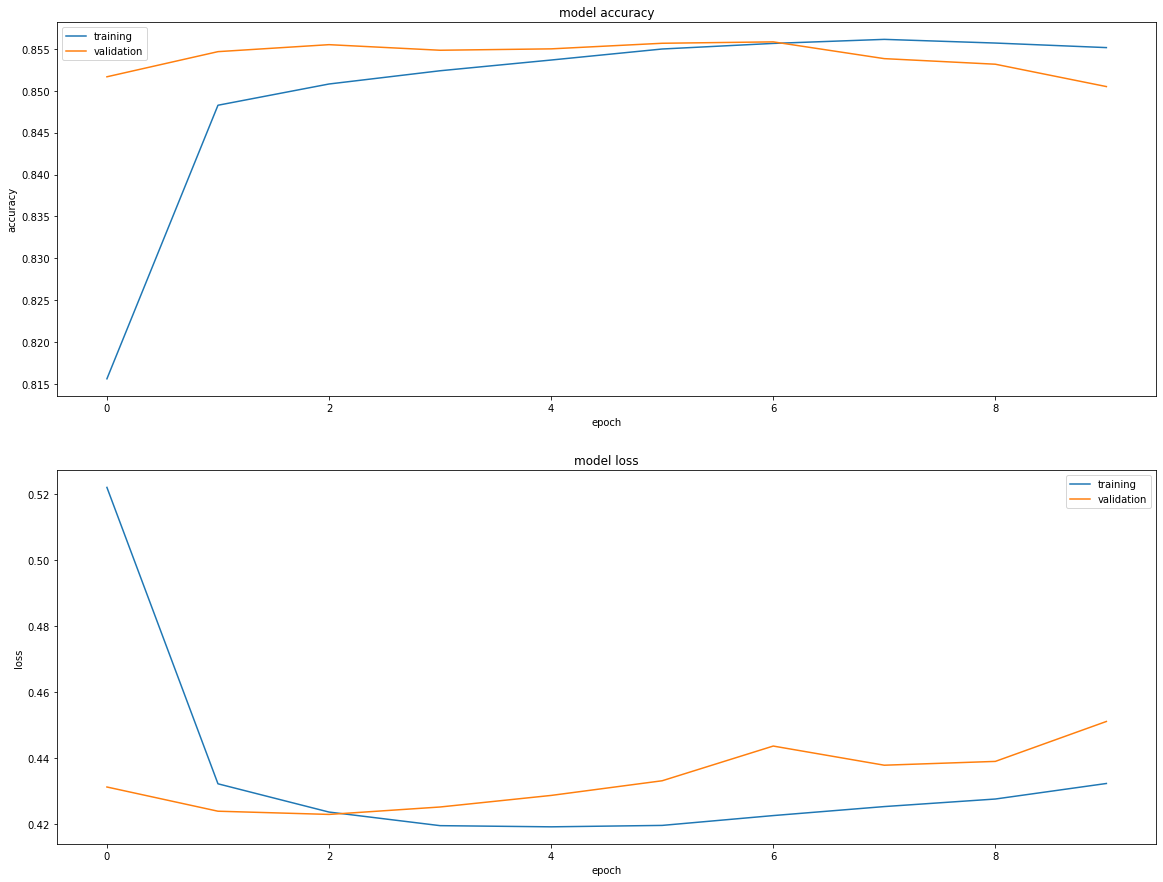

In [105]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [106]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_08.predict(int_test_ds), axis=-1)

238/238 [==============================] - 1s 3ms/step


In [107]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1900
           1       0.90      0.92      0.91      1900
           2       0.86      0.76      0.81      1900
           3       0.78      0.85      0.81      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Accuracy Score: 0.8463157894736842
Root Mean Square Error: 0.6921552913677833


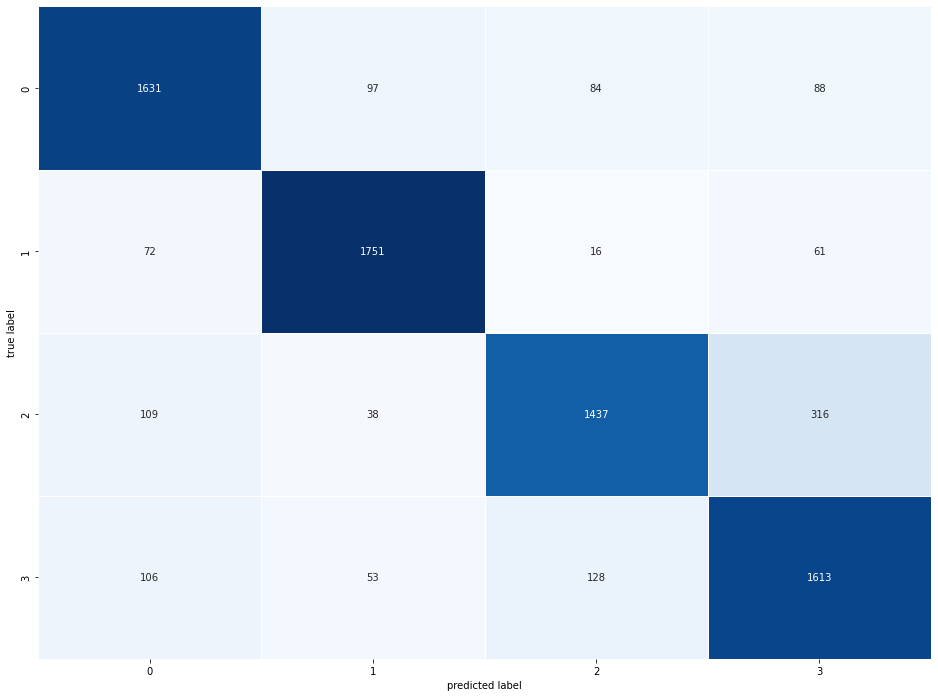

In [108]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 9: CNN 1D

- layers.TextVectorization(output_sequence_length): 96 (CONSTANT)
- layers.Dropout(dropout): 0.2 (CONSTANT)
- layers.Conv1D(kernel_size): 5 (VARIABLE)
- layers.Conv1D(filters): 32 (CONSTANT)
- layers.Embedding(depth): 1000 (CONSTANT)
- layers.Dense(units): 256 (CONSTANT)

In [113]:
# output_sequence_length=96 # CONSTANT
# dropout = 0.2 # CONSTANT
kernel_size = 5 # VARIABLE
# filters = 32 # CONSTANT
# input_dim = 1000 # CONSTANT, embedded one-hot encoding depth
# units = 256 # CONSTANT

In [114]:
print('dropout:', dropout)
print('kernel_size:', kernel_size)
print('filters:', filters)
print('input_dim:', input_dim) # embedded one-hot encoding depth
print('units:', units)
print('output_sequence_length:', output_sequence_length)

dropout: 0.2
kernel_size: 5
filters: 32
input_dim: 1000
units: 256
output_sequence_length: 96


In [115]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=input_dim)
x = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(embedded)
x = layers.Dropout(dropout)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(units, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_09 = tf.keras.Model(inputs, outputs)
model_09.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_09.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 1000)        0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          160032    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                              

In [116]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1Dcnn_09_osl_96_do_02_ker_5.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [117]:
history=model_09.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
3563/3563 [==============================] - 23s 6ms/step - loss: 0.5236 - accuracy: 0.8138 - val_loss: 0.4303 - val_accuracy: 0.8522
Epoch 2/200
3563/3563 [==============================] - 23s 6ms/step - loss: 0.4320 - accuracy: 0.8478 - val_loss: 0.4219 - val_accuracy: 0.8543
Epoch 3/200
3563/3563 [==============================] - 23s 7ms/step - loss: 0.4214 - accuracy: 0.8514 - val_loss: 0.4199 - val_accuracy: 0.8572
Epoch 4/200
3563/3563 [==============================] - 23s 6ms/step - loss: 0.4182 - accuracy: 0.8538 - val_loss: 0.4238 - val_accuracy: 0.8523
Epoch 5/200
3563/3563 [==============================] - 23s 7ms/step - loss: 0.4155 - accuracy: 0.8556 - val_loss: 0.4210 - val_accuracy: 0.8585
Epoch 6/200
3563/3563 [==============================] - 23s 7ms/step - loss: 0.4164 - accuracy: 0.8566 - val_loss: 0.4289 - val_accuracy: 0.8548
Epoch 7/200
3563/3563 [==============================] - 23s 7ms/step - loss: 0.4179 - accuracy: 0.8574 - val_loss: 0.4339 -

In [118]:
model_09 = keras.models.load_model("1Dcnn_09_osl_96_do_02_ker_5.h5")
print(f"Test acc: {model_09.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 4ms/step - loss: 0.4354 - accuracy: 0.8500
Test acc: 0.850


In [119]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [120]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.418,0.854,0.424,0.852
4,0.415,0.856,0.421,0.859
5,0.416,0.857,0.429,0.855
6,0.418,0.857,0.434,0.853
7,0.420,0.858,0.441,0.853


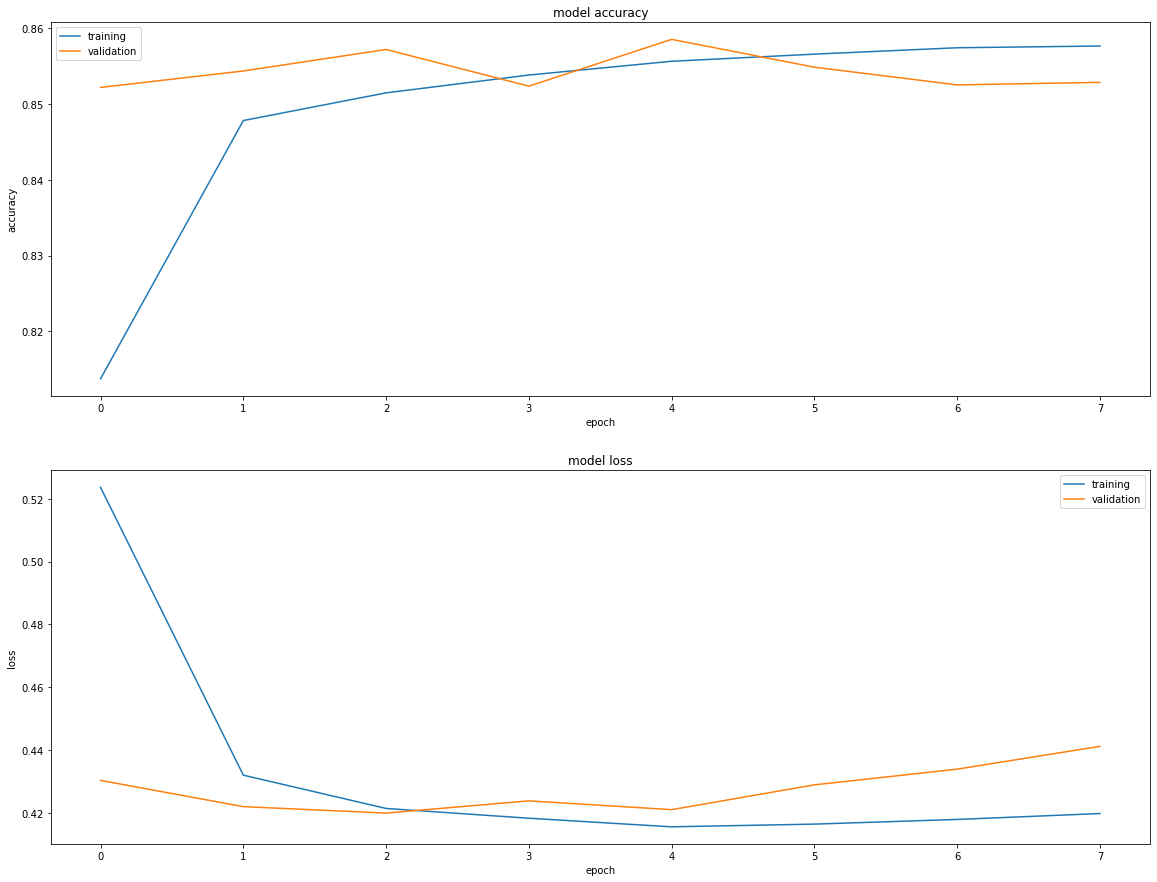

In [121]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [122]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_09.predict(int_test_ds), axis=-1)

238/238 [==============================] - 1s 3ms/step


In [123]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1900
           1       0.89      0.93      0.91      1900
           2       0.86      0.77      0.81      1900
           3       0.79      0.84      0.82      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Accuracy Score: 0.85
Root Mean Square Error: 0.6809436177293358


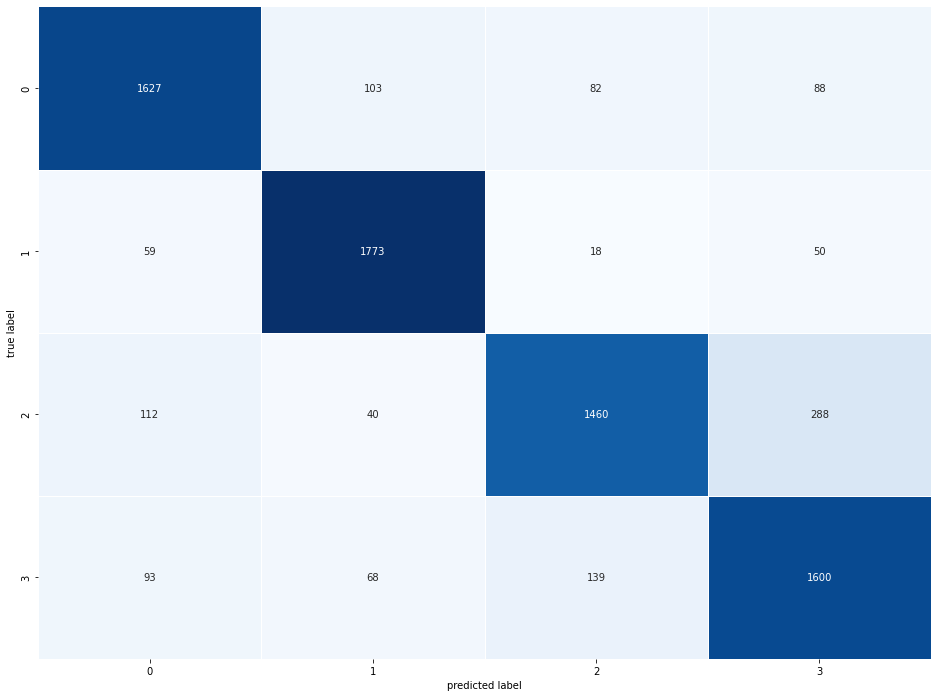

In [124]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 10: CNN 1D

- layers.TextVectorization(output_sequence_length): 96 (CONSTANT)
- layers.Dropout(dropout): 0.2 (CONSTANT)
- layers.Conv1D(kernel_size): 6 (VARIABLE)
- layers.Conv1D(filters): 32 (CONSTANT)
- layers.Embedding(depth): 1000 (CONSTANT)
- layers.Dense(units): 256 (CONSTANT)

In [125]:
# output_sequence_length=96 # CONSTANT
# dropout = 0.2 # CONSTANT
kernel_size = 6 # VARIABLE
# filters = 32 # CONSTANT
# input_dim = 1000 # CONSTANT, embedded one-hot encoding depth
# units = 256 # CONSTANT

In [126]:
print('dropout:', dropout)
print('kernel_size:', kernel_size)
print('filters:', filters)
print('input_dim:', input_dim) # embedded one-hot encoding depth
print('units:', units)
print('output_sequence_length:', output_sequence_length)

dropout: 0.2
kernel_size: 6
filters: 32
input_dim: 1000
units: 256
output_sequence_length: 96


In [127]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=input_dim)
x = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(embedded)
x = layers.Dropout(dropout)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(units, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_10 = tf.keras.Model(inputs, outputs)
model_10.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 1000)        0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          192032    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                              

In [128]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1Dcnn_10_osl_96_do_02_ker_6.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [129]:
history=model_10.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.5285 - accuracy: 0.8112 - val_loss: 0.4336 - val_accuracy: 0.8493
Epoch 2/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4300 - accuracy: 0.8482 - val_loss: 0.4200 - val_accuracy: 0.8522
Epoch 3/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4167 - accuracy: 0.8535 - val_loss: 0.4172 - val_accuracy: 0.8563
Epoch 4/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4102 - accuracy: 0.8566 - val_loss: 0.4195 - val_accuracy: 0.8558
Epoch 5/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4079 - accuracy: 0.8589 - val_loss: 0.4186 - val_accuracy: 0.8595
Epoch 6/200
3563/3563 [==============================] - 25s 7ms/step - loss: 0.4071 - accuracy: 0.8607 - val_loss: 0.4214 - val_accuracy: 0.8575
Epoch 7/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4082 - accuracy: 0.8614 - val_loss: 0.4272 -

In [130]:
model_10 = keras.models.load_model("1Dcnn_10_osl_96_do_02_ker_6.h5")
print(f"Test acc: {model_10.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 3ms/step - loss: 0.4358 - accuracy: 0.8474
Test acc: 0.847


In [119]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [120]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.418,0.854,0.424,0.852
4,0.415,0.856,0.421,0.859
5,0.416,0.857,0.429,0.855
6,0.418,0.857,0.434,0.853
7,0.420,0.858,0.441,0.853


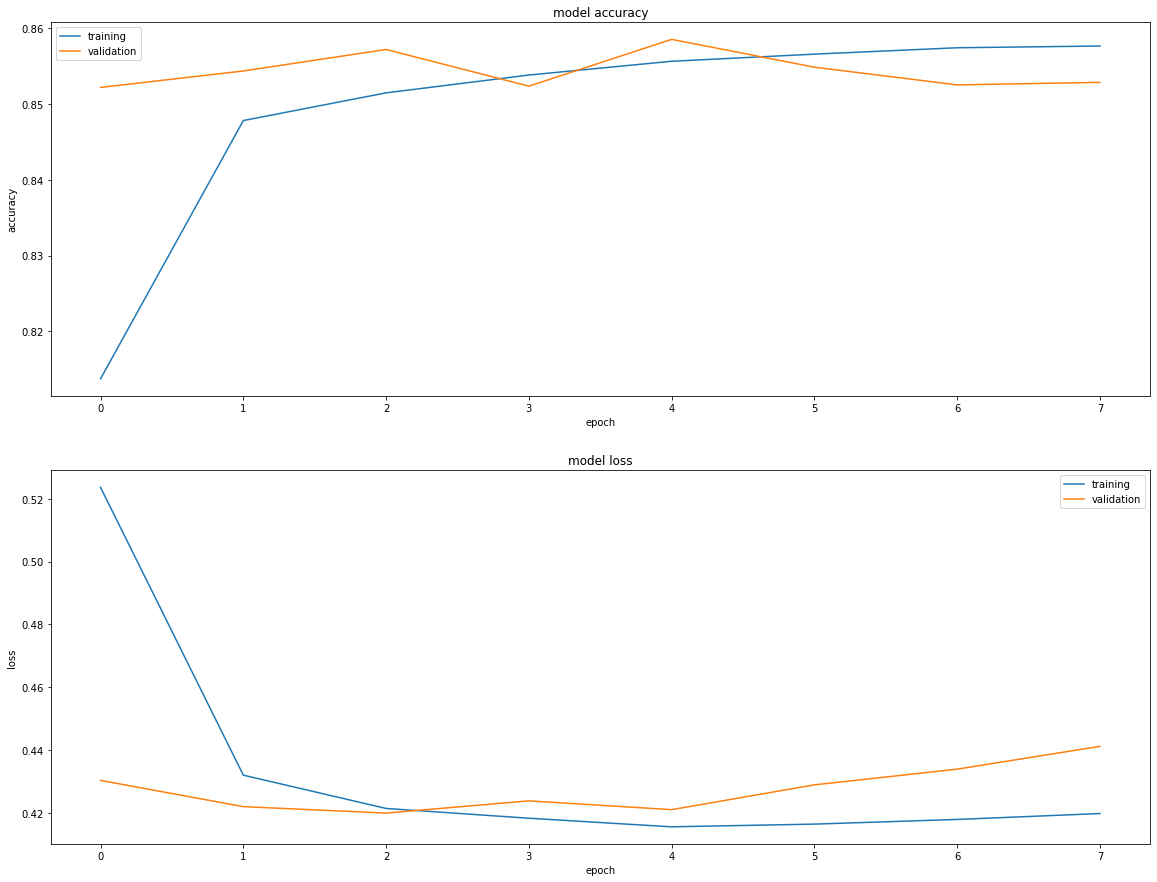

In [121]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [122]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_10.predict(int_test_ds), axis=-1)

238/238 [==============================] - 1s 3ms/step


In [123]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1900
           1       0.89      0.93      0.91      1900
           2       0.86      0.77      0.81      1900
           3       0.79      0.84      0.82      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Accuracy Score: 0.85
Root Mean Square Error: 0.6809436177293358


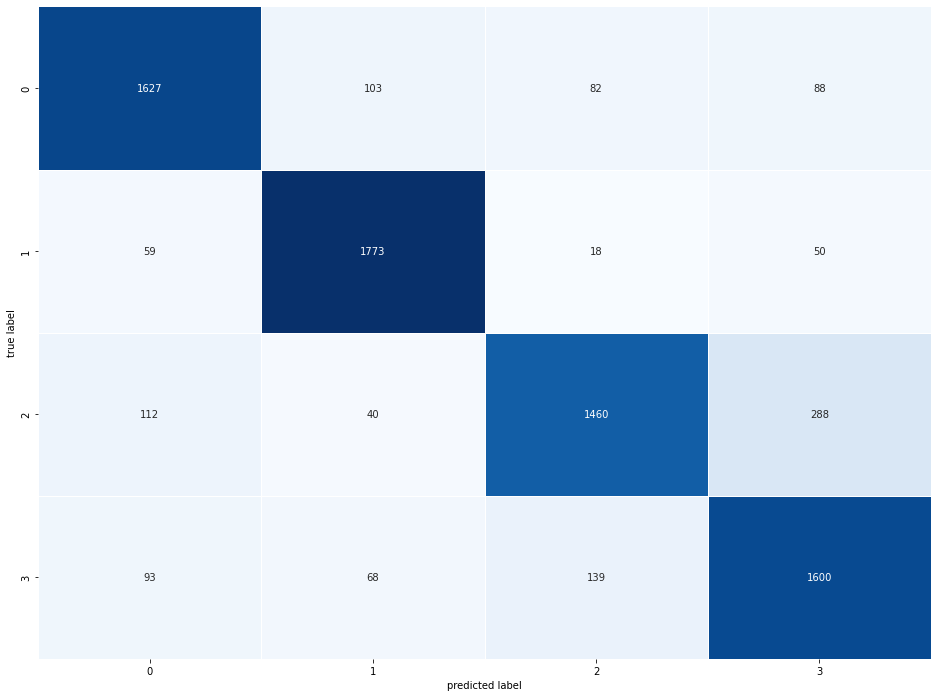

In [124]:
plot_confusion_matrix(y_test,pred_classes)

### Experiment 11: CNN 1D

- layers.TextVectorization(output_sequence_length): 96 (CONSTANT)
- layers.Dropout(dropout): 0.2 (CONSTANT)
- layers.Conv1D(kernel_size): 5 (CONSTANT)
- layers.Conv1D(filters): 64 (VARIABLE)
- layers.Embedding(depth): 1000 (CONSTANT)
- layers.Dense(units): 256 (CONSTANT)

In [136]:
# output_sequence_length=96 # CONSTANT
# dropout = 0.2 # CONSTANT
kernel_size = 5 # CONSTANT
filters = 64 # VARIABLE
# input_dim = 1000 # CONSTANT, embedded one-hot encoding depth
# units = 256 # CONSTANT

In [137]:
print('dropout:', dropout)
print('kernel_size:', kernel_size)
print('filters:', filters)
print('input_dim:', input_dim) # embedded one-hot encoding depth
print('units:', units)
print('output_sequence_length:', output_sequence_length)

dropout: 0.2
kernel_size: 5
filters: 64
input_dim: 1000
units: 256
output_sequence_length: 96


In [138]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=input_dim)
x = layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(embedded)
x = layers.Dropout(dropout)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(units, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x)
model_11 = tf.keras.Model(inputs, outputs)
model_11.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_11.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 1000)        0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          320064    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                              

In [139]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1Dcnn_11_osl_96_do_02_ker_5_fil_64.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [140]:
history=model_11.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)

Epoch 1/200
3563/3563 [==============================] - 24s 6ms/step - loss: 0.5039 - accuracy: 0.8209 - val_loss: 0.4231 - val_accuracy: 0.8558
Epoch 2/200
3563/3563 [==============================] - 23s 6ms/step - loss: 0.4213 - accuracy: 0.8518 - val_loss: 0.4116 - val_accuracy: 0.8603
Epoch 3/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4109 - accuracy: 0.8561 - val_loss: 0.4090 - val_accuracy: 0.8597
Epoch 4/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4052 - accuracy: 0.8599 - val_loss: 0.4101 - val_accuracy: 0.8615
Epoch 5/200
3563/3563 [==============================] - 24s 7ms/step - loss: 0.4058 - accuracy: 0.8608 - val_loss: 0.4164 - val_accuracy: 0.8590
Epoch 6/200
3563/3563 [==============================] - 23s 6ms/step - loss: 0.4064 - accuracy: 0.8631 - val_loss: 0.4257 - val_accuracy: 0.8573
Epoch 7/200
3563/3563 [==============================] - 23s 6ms/step - loss: 0.4074 - accuracy: 0.8627 - val_loss: 0.4268 -

In [141]:
model_11 = keras.models.load_model("1Dcnn_11_osl_96_do_02_ker_5_fil_64.h5")
print(f"Test acc: {model_11.evaluate(int_test_ds)[1]:.3f}")

238/238 [==============================] - 1s 3ms/step - loss: 0.4222 - accuracy: 0.8503
Test acc: 0.850


In [119]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [120]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,0.418,0.854,0.424,0.852
4,0.415,0.856,0.421,0.859
5,0.416,0.857,0.429,0.855
6,0.418,0.857,0.434,0.853
7,0.420,0.858,0.441,0.853


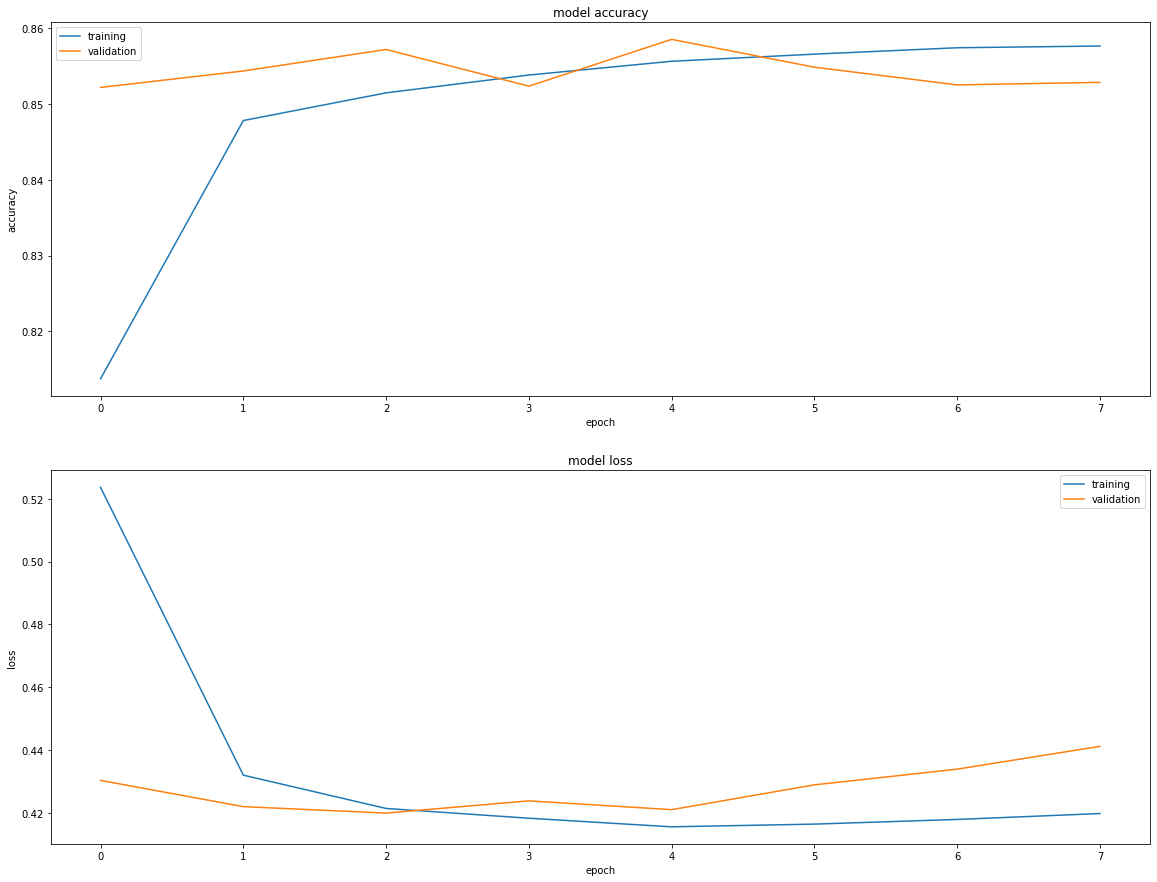

In [121]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [122]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_11.predict(int_test_ds), axis=-1)

238/238 [==============================] - 1s 3ms/step


In [123]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1900
           1       0.89      0.93      0.91      1900
           2       0.86      0.77      0.81      1900
           3       0.79      0.84      0.82      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Accuracy Score: 0.85
Root Mean Square Error: 0.6809436177293358


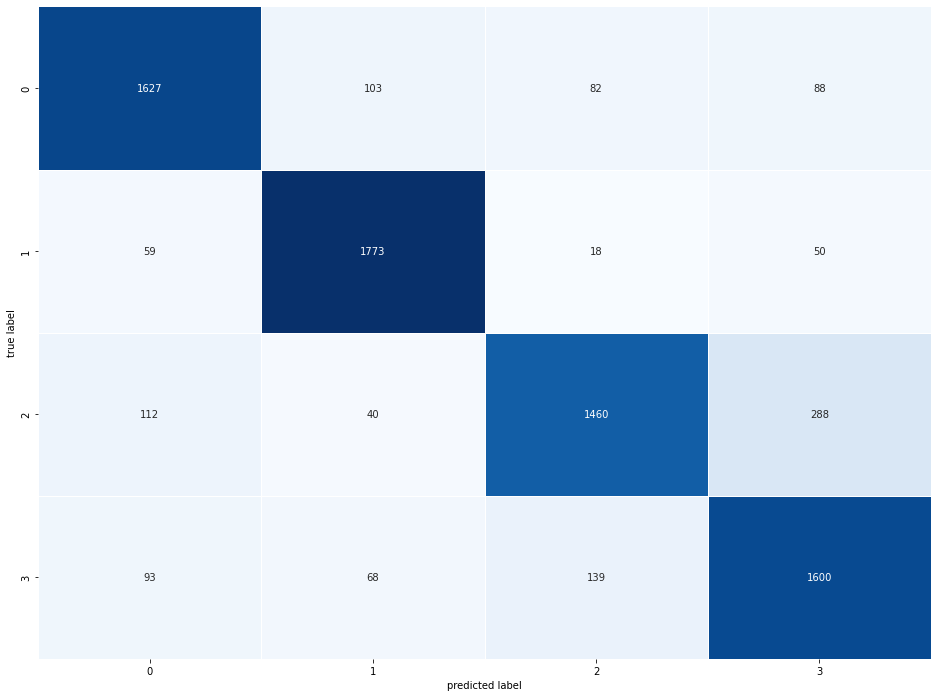

In [124]:
plot_confusion_matrix(y_test,pred_classes)